### Using Intake Catalogs Served by Dora

In [1]:
import xarray as xr
import doralite as dl
import pandas as pd
import momgrid as mg
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

#### Define some common preferences

In [2]:
# Define preferences for what kind of data you wish to analyze. The lists below
# define the priorities for the post-processing realms and chunk frequencies.
# If data are not found in the first element, the .find() method will look in
# the subsequent elements until valid data are found

preferred_realm = ["ocean_annual_z", "ocean_annual", "ocean_annual_z_1x1deg"]
preferred_chunkfreq = ["5yr", "20yr"]

# Define common keyword parameters for all datasets. Below we will search for
# average-type files that contain thetao at yearly time resolution. Note how
# we pass our preferences for preferred realm and chunk frequency
kwargs = {
    "var":"thetao",
    "freq":"yearly",
    "kind":"av",
    "preferred_realm":preferred_realm,
    "preferred_chunkfreq":preferred_chunkfreq,
}

#### Load data from experiments

In [3]:
# The first experiment is a JRA-55do OM5 "b10" experiment. We will load the
# intake catalog first from dora, find our requested data, and then load as
# an xarray datatset.

catalog = dl.load_dora_catalog("odiv-496")
catalog = catalog.find(trange=("1958-01-01", "1973-12-31"), **kwargs)
ds_reference = catalog.to_xarray(dmget=True)

In [4]:
# The second experiment is an OM5 simulation forced with 3-hourly fluxes saved
# from a preindustrial control simulation of CM4.5. Note how the time period is
# different for this experiment.

catalog = dl.load_dora_catalog("odiv-512")
catalog = catalog.find(trange=("0001-01-01", "0015-12-31"), **kwargs)
ds_exp = catalog.to_xarray(dmget=True)

Tip: The resulting xarray datasets have a global attribue `time_range` that includes the starting and ending time values of the actual data that were loaded. This can be very useful when annotating plots with time stamps.

#### Associate ocean output data with coordinates

In [5]:
# Ocean model postprocessing files, by default, do not contain the required coordinate 
# variables necessary for proper manipulation. The `momgrid.Gridset` object marries each 
# ocean variable with its coordinate variables and defines them properly within xarray.
# These variables are important for proper area weighting, regridding, and for plotting. 
# Normally this is done by opening the `ocean_static.nc` file but the momgrid package
# handles these operations.

ds_reference = mg.Gridset(ds_reference).data
ds_exp = mg.Gridset(ds_exp).data

#### Isolate the variable of interest and calculate the difference

In [6]:
# Note that for 3D ocean data, z_l = 0 is the same as the surface

varname = "thetao"
z_l_index = 0

# select the top level
reference = ds_reference[varname].isel(z_l=z_l_index)
exp = ds_exp[varname].isel(z_l=z_l_index)

# take the time mean
reference = reference.mean("time", keep_attrs=True)
exp = exp.mean("time", keep_attrs=True)

difference = exp - reference

#### Calculate the bias metrics

In [7]:
# Here is a simple xarray function that calculates the area-weighted bias and rmse

def calc_stats(arr1, arr2, area=None, xdim="lon", ydim="lat"):
    diff = arr1 - arr2
    x = diff[xdim]
    y = diff[ydim]
    if area is None:
        area = ml.util.standard_grid_cell_area(y,x)
    bias = diff.weighted(area).mean((xdim,ydim))
    rmse = np.sqrt(diff*diff).weighted(area).mean((xdim,ydim))
    return (float(bias), float(rmse))

In [8]:
# Get areacello and mask it over land points
area = xr.where(reference.isnull(),0.,reference.areacello)
wet = xr.where(reference.isnull(),np.nan,1.)

In [9]:
# Calculate metrics
bias, rmse = calc_stats(exp, reference, area=area, xdim="xh", ydim="yh")
print(f"Bias = {bias}    RMSE = {rmse}")

Bias = -1.184559941291809    RMSE = 1.2105046510696411


#### Construct a 3-panel plot

In [10]:
# In order to construct a 3-panel plot, first we define a simple function to plot just one panel.


def plot_panel(
    arr,
    mask=1.0,
    xcoord="geolon",
    ycoord="geolat",
    ax=None,
    projection=None,
    vmin=None,
    vmax=None,
    label=None,
    stats=None,
    robust=True,
    cmap=None,
):
    # # Set a default map projection if not provided
    projection = (
        ccrs.Robinson(central_longitude=-160) if projection is None else projection
    )

    # # If axis is not specified, generate a new figure
    if ax is None:
        fig = plt.figure(dpi=150, figsize=(6, 3))
        ax = plt.subplot(1, 1, 1, projection=projection, facecolor="gray")

    if vmin is None and vmax is None:
        # Use xarray's built-in plotting method
        cb = (arr * mask).plot(
            transform=ccrs.PlateCarree(),
            x=xcoord,
            y=ycoord,
            robust=robust,
            add_colorbar=False,
            cmap=cmap,
        )
    else:
        cb = ax.pcolormesh(
            arr[xcoord],
            arr[ycoord],
            arr * mask,
            transform=ccrs.PlateCarree(),
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
        )

    if stats is not None:
        bias, rmse = stats
        ax.text(
            0.5,
            -0.05,
            f"Bias = {round(bias,4)}     RMSE = {round(rmse,4)}",
            ha="center",
            fontsize=7,
            transform=ax.transAxes,
        )
        pad = 0.08
    else:
        pad = 0.05

    cbar = ax.figure.colorbar(
        cb,
        ax=ax,
        orientation="horizontal",
        extend="both",
        pad=pad,
        shrink=0.8,
        aspect=50,
        label=label,
    )

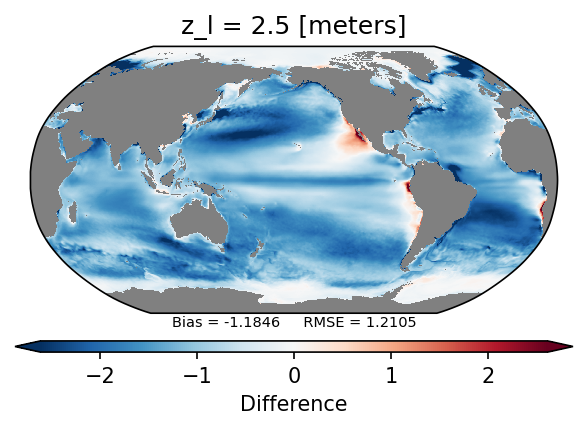

In [11]:
# Plot one panel
plot_panel(difference, mask=wet, stats=(bias, rmse), label="Difference")

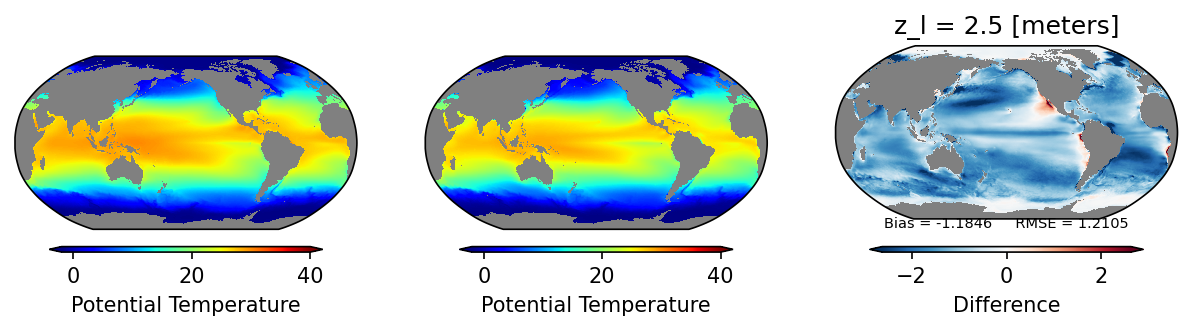

In [12]:
# Now let's define the full three panel plot

projection = ccrs.Robinson(central_longitude=-160)
fig = plt.figure(figsize=(10, 3), dpi=150)

ax1 = plt.subplot(1, 3, 1, projection=projection, facecolor="gray")
plot_panel(
    reference,
    ax=ax1,
    mask=wet,
    cmap="jet",
    vmin=-2,
    vmax=40,
    label=reference.attrs["long_name"],
)

ax2 = plt.subplot(1, 3, 2, projection=projection, facecolor="gray")
plot_panel(
    exp, ax=ax2, mask=wet, cmap="jet", vmin=-2, vmax=40, label=exp.attrs["long_name"]
)

ax3 = plt.subplot(1, 3, 3, projection=projection, facecolor="gray")
plot_panel(difference, ax=ax3, mask=wet, stats=(bias, rmse), label="Difference")

#### BONUS - Loop over all variables

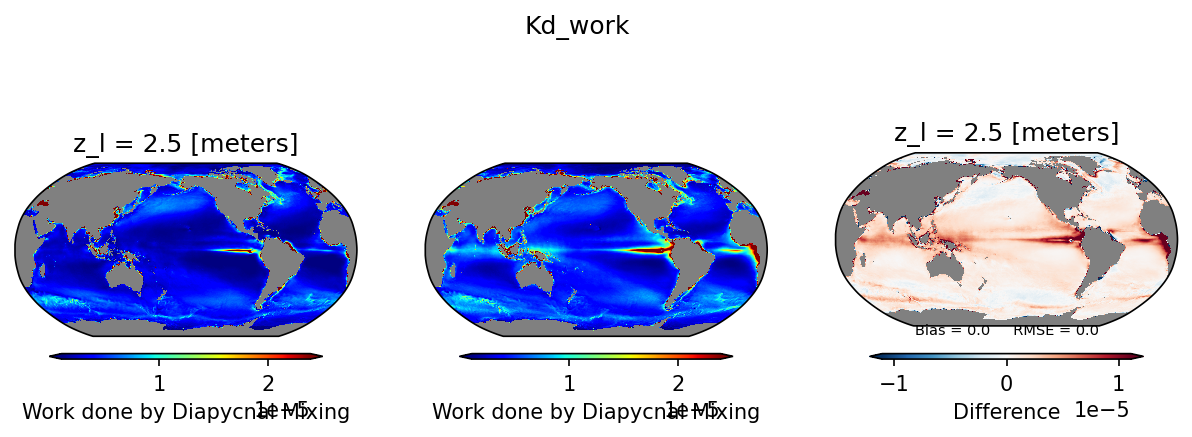

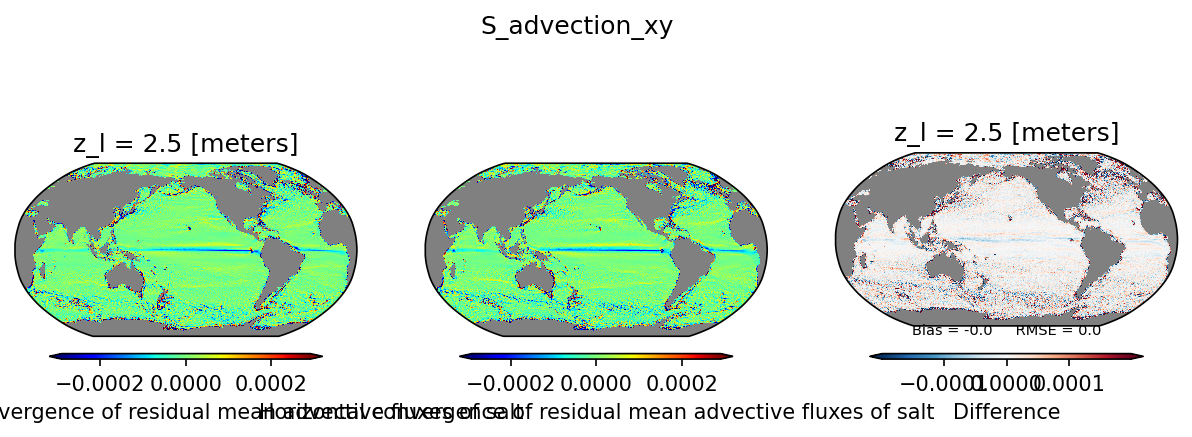

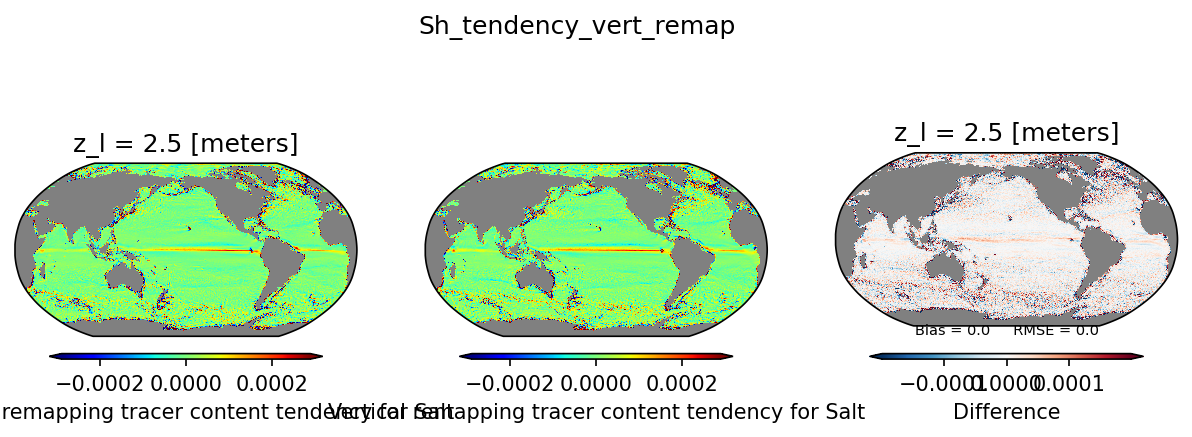

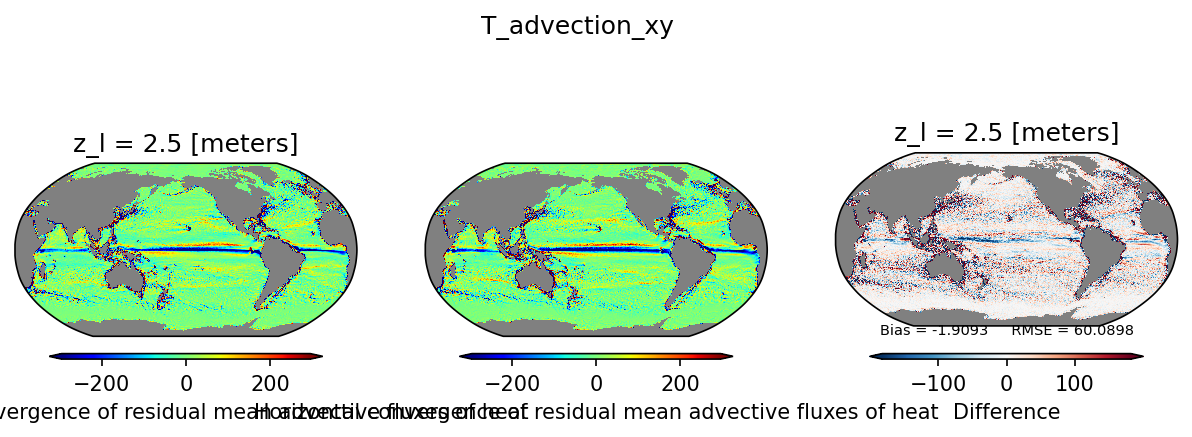

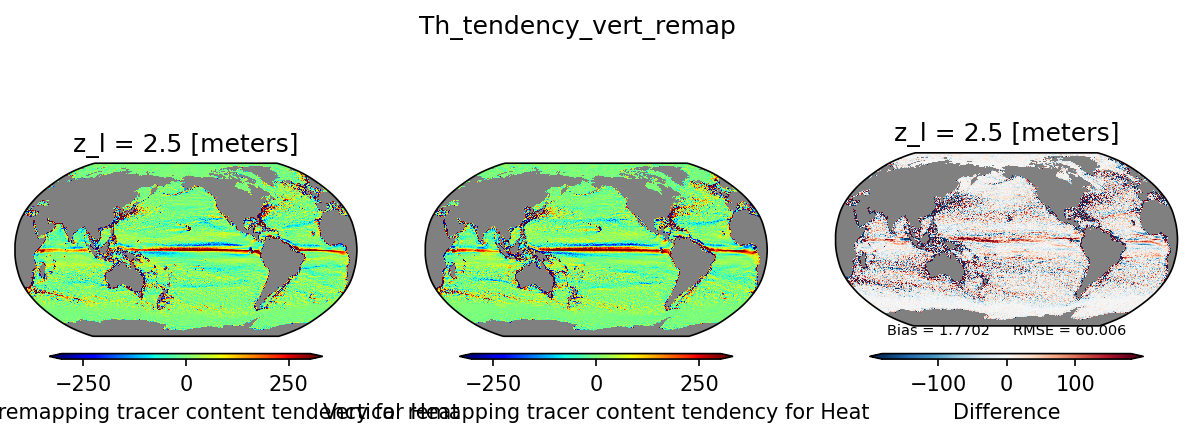

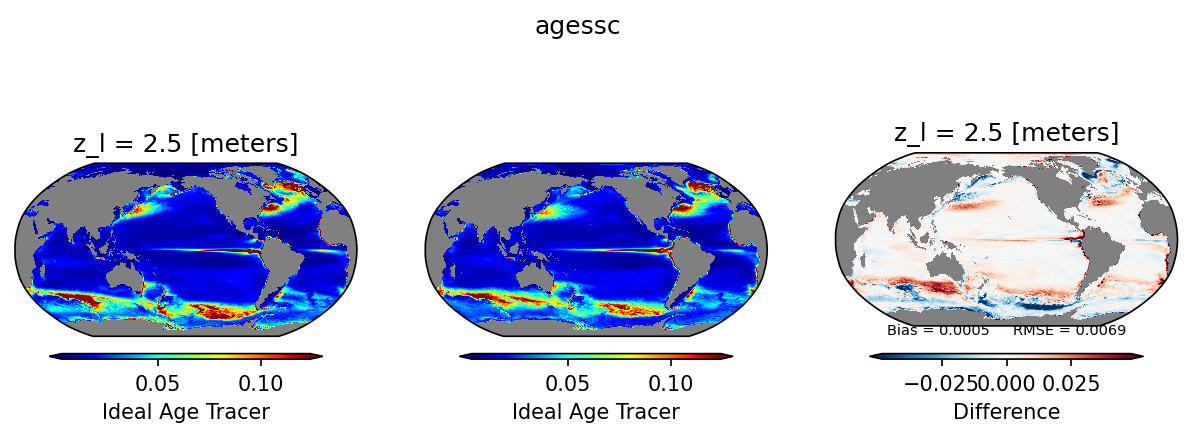

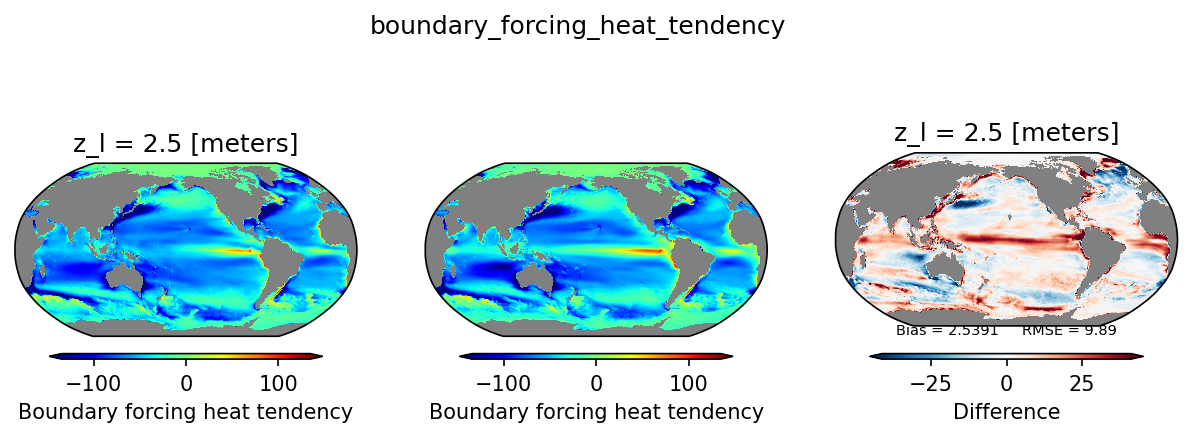

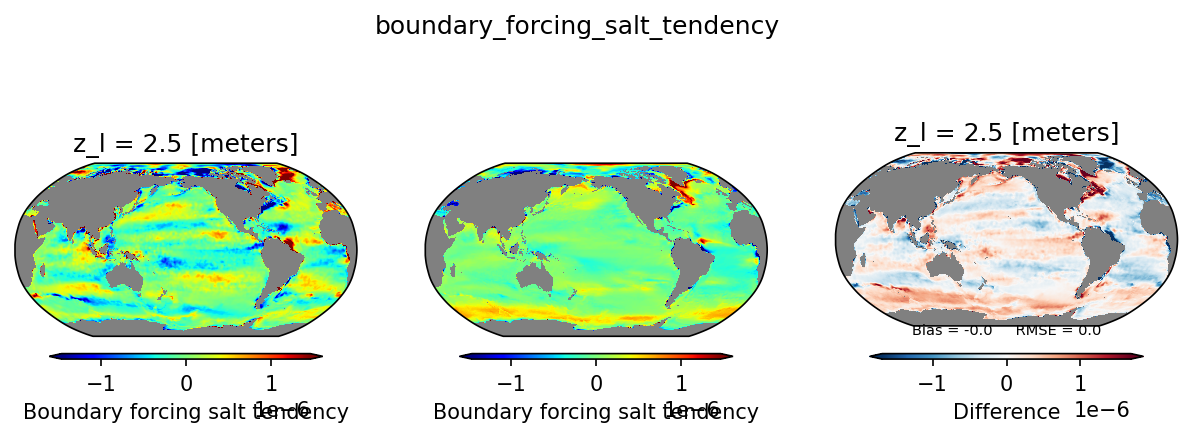

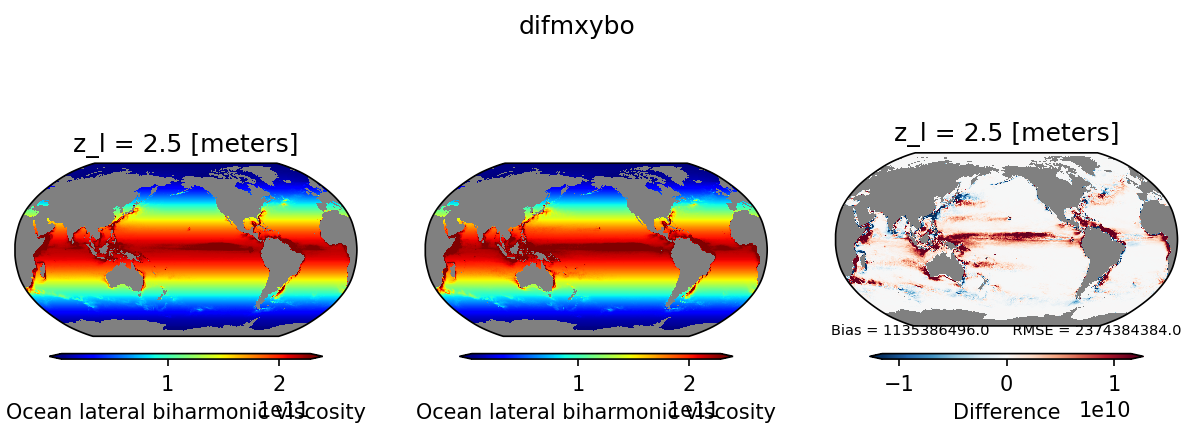

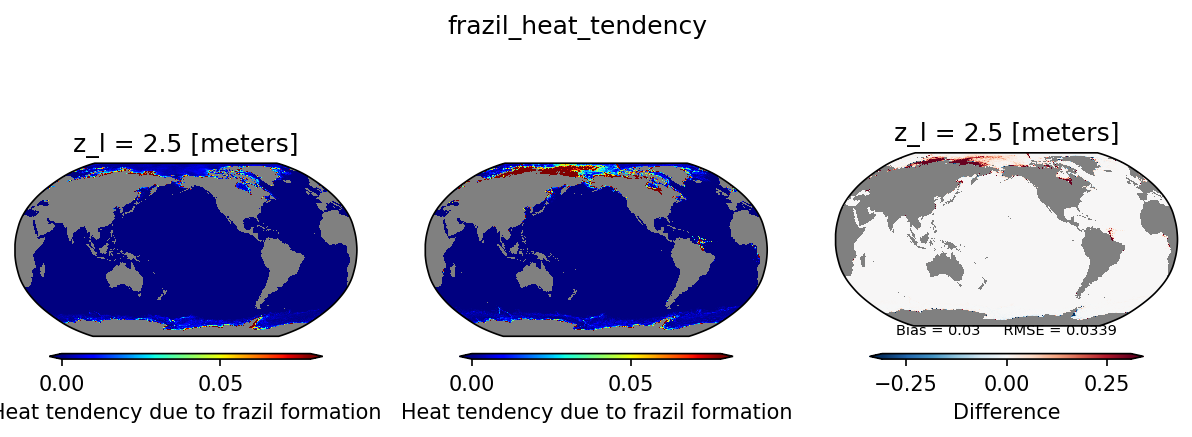

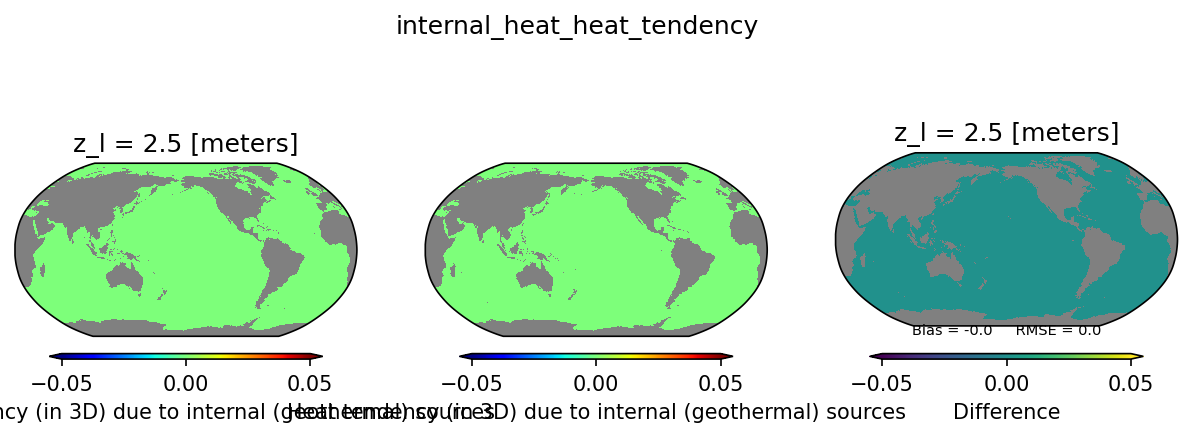

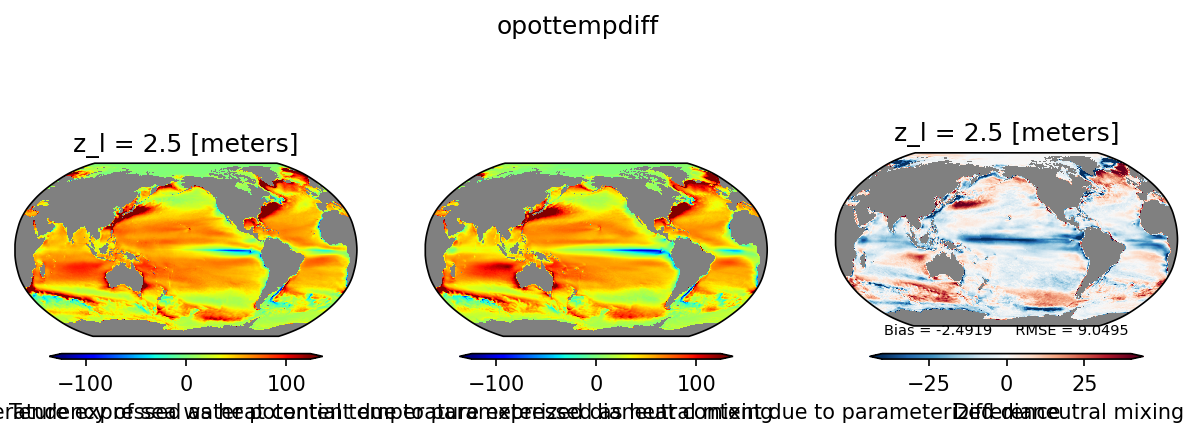

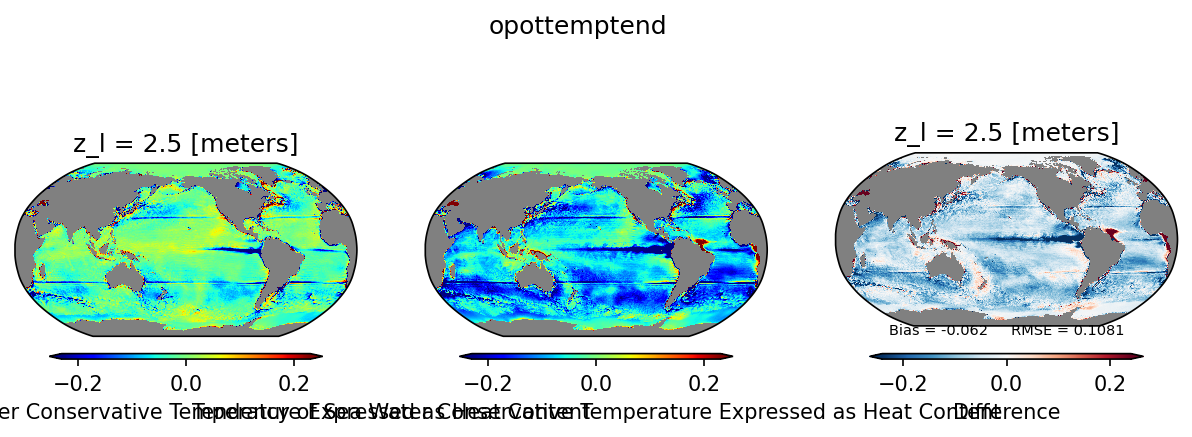

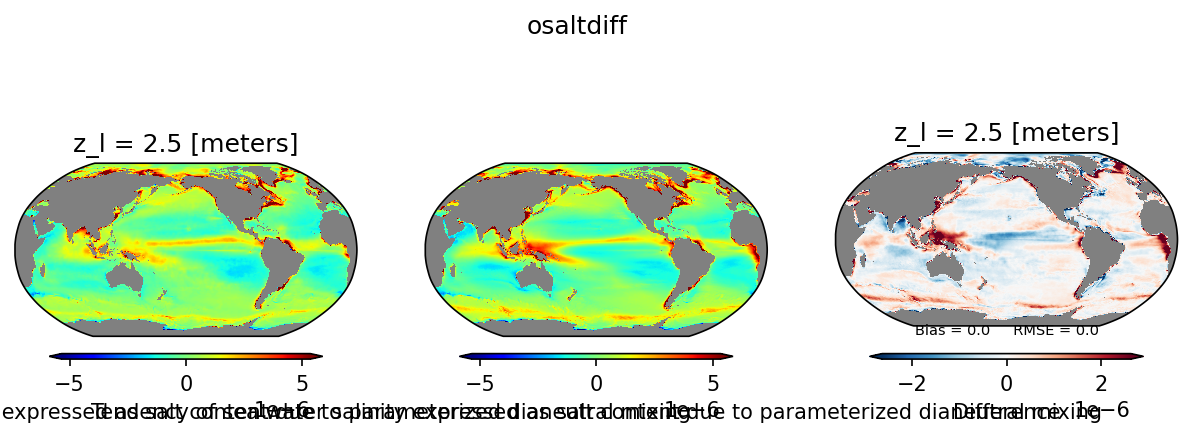

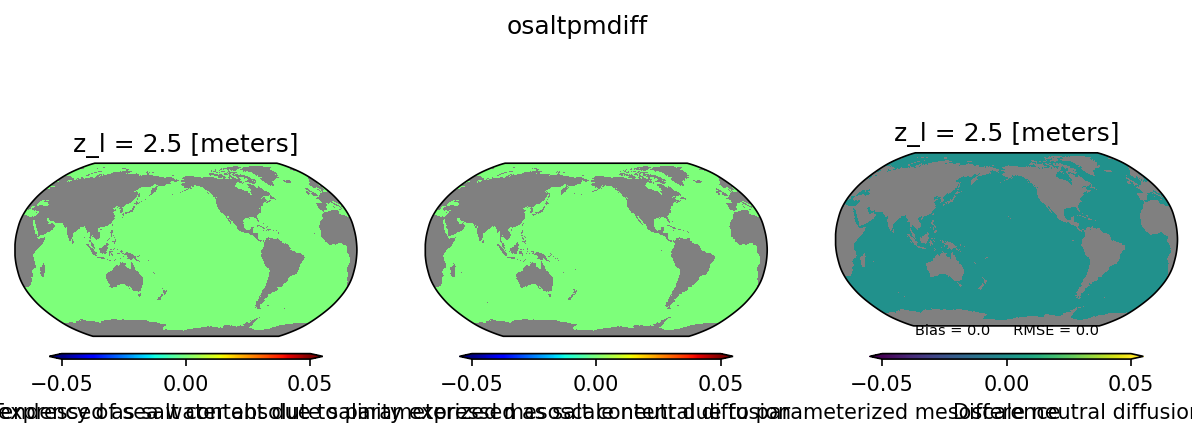

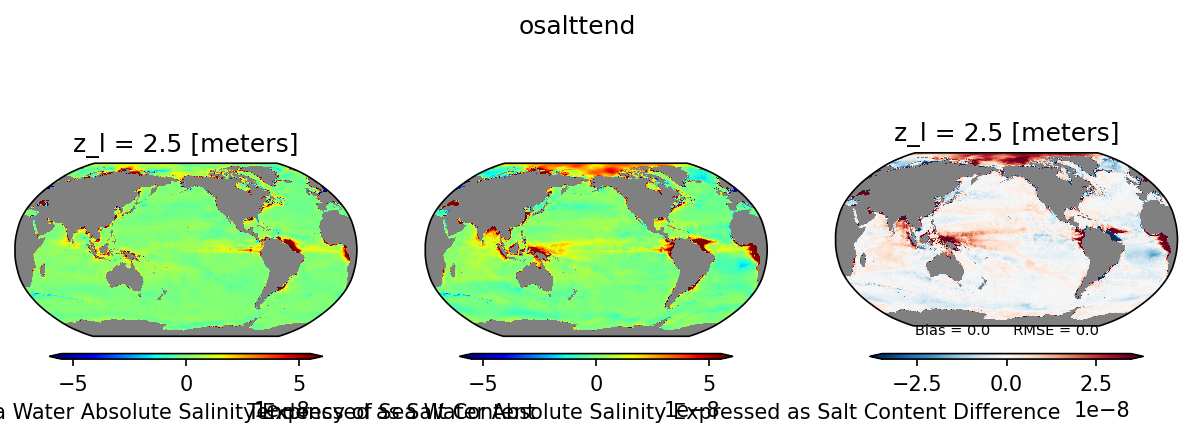

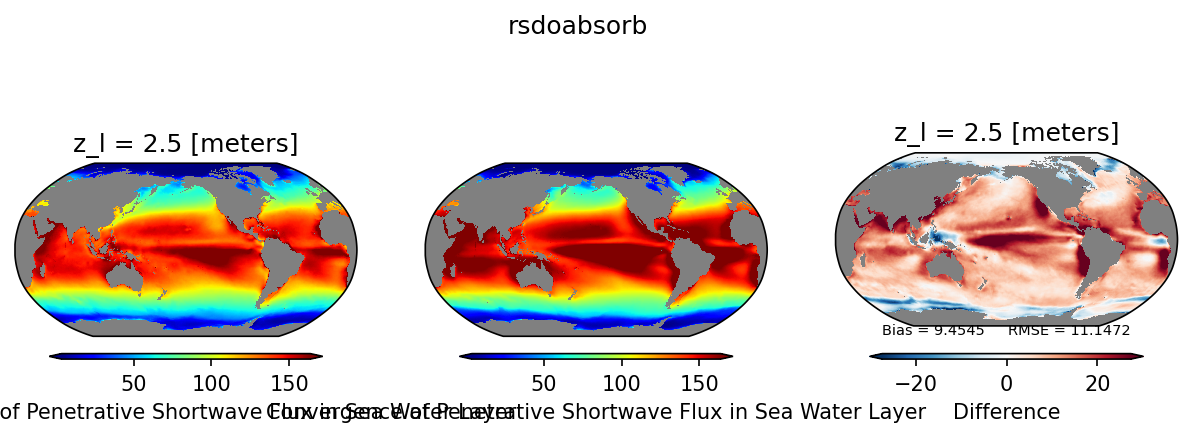

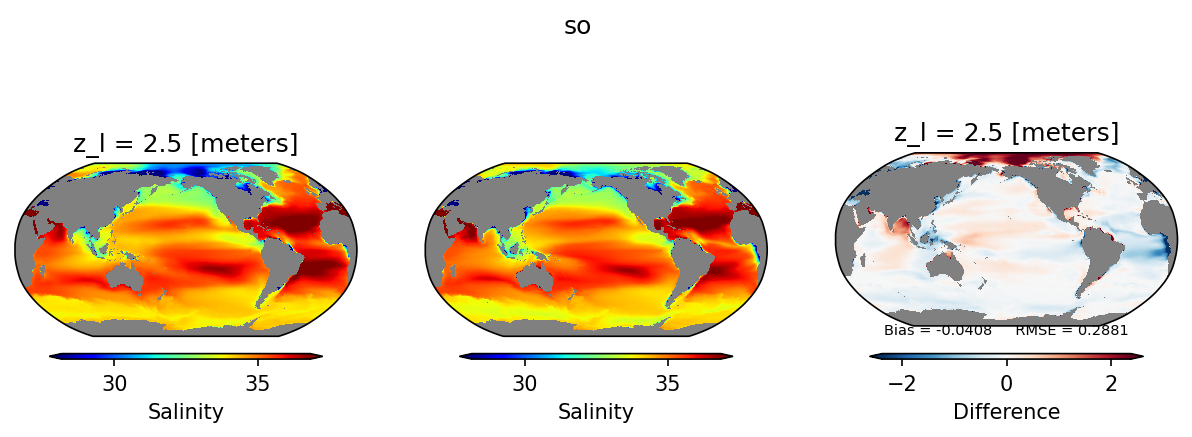

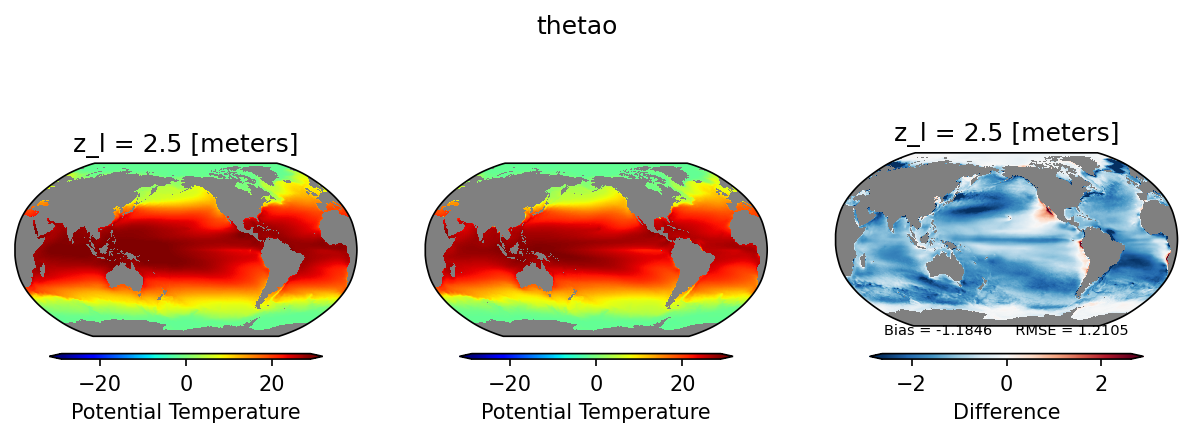

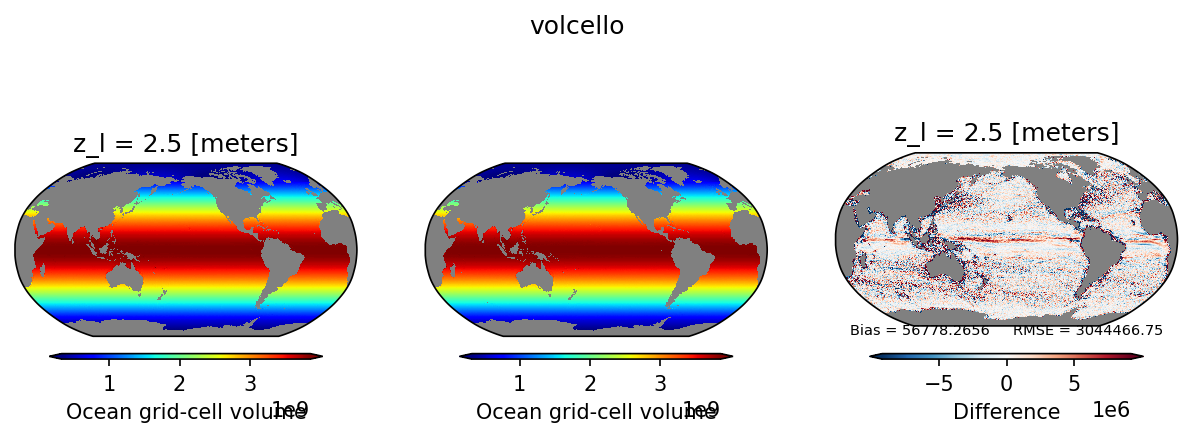

In [13]:
# Since we used an "av" post-processing file, we have many more variables to look at.  Lets loop over all available variables:

ds_diff = ds_exp - ds_reference

varlist = sorted(list(ds_diff.keys()))
varlist = [x for x in varlist if "_xyave" not in x]
varlist = [x for x in varlist if "_bnds" not in x]

# restrict ourselves to tracer points for simplicity
varlist = [x for x in varlist if "xh" in list(ds_diff[x].coords)]
varlist = [x for x in varlist if "yh" in list(ds_diff[x].coords)]
varlist = [x for x in varlist if "z_l" in list(ds_diff[x].coords)]

for varname in varlist:
    z_l_index = 0
    
    # select the top level
    reference = ds_reference[varname].isel(z_l=z_l_index)
    exp = ds_exp[varname].isel(z_l=z_l_index)
    
    # take the time mean
    reference = reference.mean("time", keep_attrs=True)
    exp = exp.mean("time", keep_attrs=True)
    
    difference = exp - reference

    bias, rmse = calc_stats(exp, reference, area=area, xdim="xh", ydim="yh")

    projection = ccrs.Robinson(central_longitude=-160)
    fig = plt.figure(figsize=(10, 3), dpi=150)
    
    ax1 = plt.subplot(1, 3, 1, projection=projection, facecolor="gray")
    plot_panel(
        reference,
        ax=ax1,
        mask=wet,
        cmap="jet",
        label=reference.attrs["long_name"],
    )

    # Use the same colorbar range
    for mappable in ax1.collections:
        if hasattr(mappable, "get_clim"):
            vmin, vmax = mappable.get_clim()
            break
    
    ax2 = plt.subplot(1, 3, 2, projection=projection, facecolor="gray")
    plot_panel(
        exp, ax=ax2, mask=wet, cmap="jet", vmin=vmin, vmax=vmax, label=exp.attrs["long_name"]
    )
    
    ax3 = plt.subplot(1, 3, 3, projection=projection, facecolor="gray")
    plot_panel(difference, ax=ax3, mask=wet, stats=(bias, rmse), label="Difference")

    plt.suptitle(varname)